In [1]:
import json
from dataclasses import dataclass
from glob import glob
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from transformers import AutoProcessor


In [2]:
data_dir = "/root/autodl-tmp/LLaVA/data"

chat_file = Path(data_dir).joinpath("chat.json")
chat_data = pd.read_json(chat_file)

chat_data.head(n=5)

,id,image,conversations
0,GCC_train_002582585,GCC_train_002582585.jpg,"[{'from': 'human', 'value': 'Provide a brief d..."
1,GCC_train_002429825,GCC_train_002429825.jpg,"[{'from': 'human', 'value': '<image> Write a t..."
2,GCC_train_000190697,GCC_train_000190697.jpg,"[{'from': 'human', 'value': 'Share a concise i..."
3,GCC_train_002503829,GCC_train_002503829.jpg,"[{'from': 'human', 'value': 'Relay a brief, cl..."
4,GCC_train_000530863,GCC_train_000530863.jpg,"[{'from': 'human', 'value': '<image> Render a ..."


In [3]:
chat_data.iloc[4]['conversations']

[{'from': 'human',
  'value': '<image>\nRender a clear and concise summary of the photo.'},
 {'from': 'gpt', 'value': 'train that takes you around the perimeter'}]

In [4]:
chat_data.iloc[4]['image']

'GCC_train_000530863.jpg'

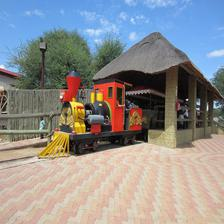

In [5]:
image_dir = Path(data_dir).joinpath("images")

test_image_file = image_dir.joinpath(chat_data.iloc[4]['image'])
Image.open(test_image_file)

In [6]:
q = chat_data.iloc[4]['conversations'][0]['value']
a = chat_data.iloc[4]['conversations'][1]['value']

q, a

('<image>\nRender a clear and concise summary of the photo.',
 'train that takes you around the perimeter')

# 定义数据类

In [7]:
@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    a_input_ids: torch.Tensor


# 创建数据集 LlavaDataset

In [17]:
class LlavaDataset(Dataset):
    def __init__(self, dataset_dir: str) -> None:
        super().__init__()
        self.chat_data, self.image_dir = self.build_dataset(dataset_dir)

    def build_dataset(self, data_dir: str) -> Tuple[List[Dict], Path]:
        data_dir = Path(data_dir)
        chat_file = data_dir.joinpath("chat.json")
        image_dir = data_dir.joinpath("images")

        chat_data = pd.read_json(chat_file).to_dict(orient="records")

        return chat_data, image_dir

    def __len__(self):
        return len(self.chat_data)

    def __getitem__(self, index) -> Tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        conversations = cur_data.get("conversations")

        human_input = conversations[0].get("value")
        chatbot_output = conversations[1].get("value")

        image_path = self.image_dir.joinpath(cur_data.get("image"))
        return human_input, chatbot_output, image_path


In [18]:
test_llavaDataset = LlavaDataset(dataset_dir=data_dir)


In [19]:
test_llavaDataset.__len__(),test_llavaDataset.__getitem__(4)

(595375,
 ('<image>\nRender a clear and concise summary of the photo.',
  'train that takes you around the perimeter',
  PosixPath('/root/autodl-tmp/LLaVA/data/images/GCC_train_000530863.jpg')))

# 转化成 tensor

In [20]:
test002 = test_llavaDataset[12345]
test002

('Describe the image concisely.\n<image>',
 'illustration of a gray goose on a white background',
 PosixPath('/root/autodl-tmp/LLaVA/data/images/GCC_train_002160298.jpg'))

In [21]:
from transformers import AutoProcessor

llava_model_name_or_path = "/root/autodl-tmp/LLaVA/model/model001"
llava_processor = AutoProcessor.from_pretrained(llava_model_name_or_path)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Qwen2Tokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path):
    # 根据 QWen 的模板
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return prompt

build_qaimage(llava_processor, test002[0], test002[1], test002[2])

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nDescribe the image concisely.\n<image><|im_end|>\n<|im_start|>assistant\n'

In [25]:
def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path):
    # 根据 QWen 的模板
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_file = image_path
    raw_image = Image.open(image_file)

    inputs = processor(prompt, raw_image, return_tensors="pt")

    return inputs

c = build_qaimage(llava_processor, test002[0], test002[1], test002[2])
c.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [28]:
c['input_ids']

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
            285,    974,    624, 151646, 151645,    198, 151644,  77091,    198]])

In [33]:
llava_processor.decode([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
            285,    974,    624, 151646, 151645,    198, 151644,  77091,    198])

'< | i m _ s t a r t | > s y s t e m \n Y o u   a r e   a   h e l p f u l   a s s i s t a n t . < | i m _ e n d | > \n < | i m _ s t a r t | > u s e r \n D e s c r i b e   t h e   i m a g e   c o n c i s e l y . \n < i m a g e > < | i m _ e n d | > \n < | i m _ s t a r t | > a s s i s t a n t'

In [35]:
c['pixel_values'].shape

torch.Size([1, 3, 336, 336])

In [36]:
c['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])

In [43]:
def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path):
    # 根据 QWen 的模板
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_file = image_path  # "000000039769.jpg"

    raw_image = Image.open(image_file)
    inputs = processor(prompt, raw_image, return_tensors="pt")  # .to(0, torch.float16)

    a_input_ids = processor.tokenizer(
        a_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
    )["input_ids"]

    res = QaImageOutput(
        q_input_ids=inputs.get("input_ids"),
        pixel_values=inputs.get("pixel_values"),
        a_input_ids=a_input_ids,
    )
    return res



In [46]:
c = build_qaimage(llava_processor, test002[0], test002[1], test002[2])

# 张量合并

In [48]:
c.q_input_ids.shape, c.a_input_ids.shape

(torch.Size([1, 27]), torch.Size([1, 10]))

In [54]:
class TrainLLavaModelCollator:
    def __init__(self, processor: AutoProcessor, IGNORE_INDEX: int) -> None:
        self.processor = processor
        self.ingnore_index = IGNORE_INDEX

    def convert_one_piece(
        self, q_input_ids: torch.Tensor, a_input_ids: torch.Tensor
    ):  # -> tuple:

        input_ids = torch.concat(
            [
                q_input_ids,
                a_input_ids,
                torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1),
            ],
            axis=1,
        )
        labels = torch.concat(
            [
                torch.full(q_input_ids.shape, self.ingnore_index),
                a_input_ids,
                torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1),
            ],
            axis=1,
        )

        return input_ids, labels
    
    def __call__(self, features: List) -> Dict[str, torch.Tensor]:
        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []

        for feature in features:
            qaimage_output = build_qaimage(
                self.processor, feature[0], feature[1], feature[2]
            )
            temp_input_ids, temp_labels = self.convert_one_piece(
                qaimage_output.q_input_ids, qaimage_output.a_input_ids
            )
            max_input_len_list.append(temp_input_ids.shape[1])
            input_ids_list.append(temp_input_ids)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)

        max_input_len = max(max_input_len_list)

        final_input_ids = torch.concat(
            [
                torch.concat(
                    [
                        torch.full(
                            (1, max_input_len - max_input_len_list[index]),
                            self.processor.tokenizer.pad_token_id,
                        ),
                        value,
                    ],
                    axis=1,
                )
                for index, value in enumerate(input_ids_list)
            ]
        )
        final_labels = torch.concat(
            [
                torch.concat(
                    [
                        torch.full(
                            (1, max_input_len - max_input_len_list[index]),
                            self.ingnore_index,
                        ),
                        value,
                    ],
                    axis=1,
                )
                for index, value in enumerate(labels_list)
            ]
        )
        final_pixel_values = torch.concat(pixel_values, axis=0)
        attention_mask = torch.ones_like(final_input_ids)
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0
        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "pixel_values": final_pixel_values,
            "attention_mask": attention_mask,
        }


In [56]:
tlmc = TrainLLavaModelCollator(llava_processor, IGNORE_INDEX=-100)
d = tlmc([test_llavaDataset[1], test_llavaDataset[100], test_llavaDataset[200]])
d.keys()

dict_keys(['input_ids', 'labels', 'pixel_values', 'attention_mask'])

In [57]:
d['input_ids']

tensor([[151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151644,   8948,    198,   2610,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198, 151646,    198,   7985,
            264,  50537,    714,  38219,  12126,    315,    279,   6802,     13,
         151645,    198, 151644,  77091,    198,     18,     67,   4621,  78424,
          27790,    315,  26618,  45620,  15430,  20748,  17738,    659, 151645],
        [151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,   6740,    352,    264,   9814,
             11,   2797,   2692,    315,    279,   6802,   6839,    624, 151646,
         151645,    198, 151644,  77091,    198,    266,   2544,  54236,   1293,
           1154,    419,  44486,    481,  11466,    572,     79,   1231,    387,
            825,    315,    279,  24632,  40811,    304,    279,   1879, 151645],
        [151643, 151643, 1

In [58]:
d['input_ids'].shape

torch.Size([3, 54])

In [59]:
dd = tlmc([test_llavaDataset[23], test_llavaDataset[100], test_llavaDataset[200]])
d['attention_mask']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])

# 数据及验证

In [60]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

llava_model_name_or_path = "/root/autodl-tmp/LLaVA/model/model001"
llava_model = LlavaForConditionalGeneration.from_pretrained(llava_model_name_or_path,
                                                            torch_dtype=torch.bfloat16,
                                                            device_map='cuda:0')

/root/miniconda3/lib/python3.12/site-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [61]:
tlmc = TrainLLavaModelCollator(llava_processor, IGNORE_INDEX=-100)
ddd = tlmc([test_llavaDataset[1], test_llavaDataset[100]])

In [62]:
for tk in ddd.keys():
    ddd[tk] = ddd[tk].to(llava_model.device)

model_output = llava_model(**ddd)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [63]:
model_output

LlavaCausalLMOutputWithPast(loss=tensor(8.5642, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[-3.4375, -2.9531, -6.8125,  ...,  1.2969,  1.3047,  1.2969],
         [-3.4375, -2.9531, -6.8125,  ...,  1.2969,  1.3047,  1.2969],
         [-3.4375, -2.9531, -6.8125,  ...,  1.2969,  1.3047,  1.2969],
         ...,
         [ 3.9375,  3.1875, -1.5703,  ..., -4.1875, -4.1562, -4.1562],
         [ 2.8281,  0.6523,  0.3398,  ..., -3.2812, -3.2812, -3.2812],
         [ 1.9688,  3.8438, -2.9062,  ..., -1.7109, -1.7109, -1.7109]],

        [[ 0.1758, -0.3477, -1.2344,  ...,  0.2617,  0.2656,  0.2656],
         [ 0.4121, -0.1406, -1.0547,  ..., -0.3438, -0.3398, -0.3398],
         [ 2.1406,  3.2969, -0.7812,  ..., -5.5625, -5.5625, -5.5625],
         ...,
         [ 2.9688, -0.2139,  1.3281,  ..., -2.9688, -2.9688, -2.9531],
         [ 4.7812,  0.7969,  1.2344,  ..., -3.2812, -3.2812, -3.2812],
         [-0.4180,  1.2188, -2.8750,  ..., -1.2188, -1.2109, -1.2109]]],
       device='

In [64]:
model_output.loss

tensor(8.5642, device='cuda:0', grad_fn=<NllLossBackward0>)